## Scope

Use case:
Plot cells from 1 or more CosMx FOVs as polygons and color cells using quantitative or qualitative attributes.

Inputs: 
{slide}-polygons.csv

Anndata (h5ad) file, e.g. exported from Seurat, containing metadata (adata.metadata) and counts (adata.X) for the FOVs of interest. 
If no anndata is parsed, one can plot the cells with random colors to visualise the segmentation

Output: image of cells as polygons

## Instructions

Use the different plotting routines depending on whether the cells are colored by metadata vs count matrix, and qualitative vs quantitative variables.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import seaborn as sns
import pandas as pd
import os
import random
import anndata as ad
#import squidpy as sq

In [24]:
csv_dir = "/mnt/share/Projects/Proj_AN1_P.chabaudi/Datasets/CosmX/ThomasOttoMouseSlide2060324/"
poly_f = "ThomasOttoMouseSlide2060324-polygons.csv"
poly= pd.read_csv(csv_dir + poly_f)

hd5_dir = "/mnt/share/Projects/Proj_AN1_P.chabaudi/Datasets/CosmX/"
slide = "TOM2" # this is the name of the folder in which the hd5f was exported from Seurat
in_hd5f = "ln_tp1_v2.h5ad"
adata = ad.read_h5ad(f"{hd5_dir}{slide}/{in_hd5f}")
adata
samples = ["TP_3_m2_spleen","TP_4_m2_spleen","TP_3_bone_marrow", "TP_N1_m2_lymph_node", "TP_4_m7_lymph_node"]
sample = samples[3]

#slide, samples = "TOM1", ["TP_N1_m2_spleen","TP_2_m1_spleen", "TP_2_m1_bone_marrow"]

outdir = "/mnt/share/Projects/Proj_AN1_P.chabaudi/Datasets/CosmX/IF_images/"

Drawing this many cells:  25533


/home/adnane/miniforge3/envs/scrnaseq3.10/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [26]:
# In case you don't want to render the whole slide, select FOVs - 
# these should be named as in the original csv output, i.e. only numbers, not string
# else set : fovs_to_sel = []
fovs_to_sel = [224 , 225 ] 
# [224 , 225 , 226 , 227 , 228 ,229, 230, 231, 232, 233, 234, 235, 236, 237] 
if len(fovs_to_sel) > 0:
    fov = poly[poly["fov"].isin(fovs_to_sel) ]
else:
    fov = poly

cells = fov["cell"].unique()
minx = fov.min()["x_global_px"]
maxx = fov.max()["x_global_px"]
miny = fov.min()["y_global_px"]
maxy = fov.max()["y_global_px"]
print("Drawing this many cells: ", len(cells))

Drawing this many cells:  25533


Done


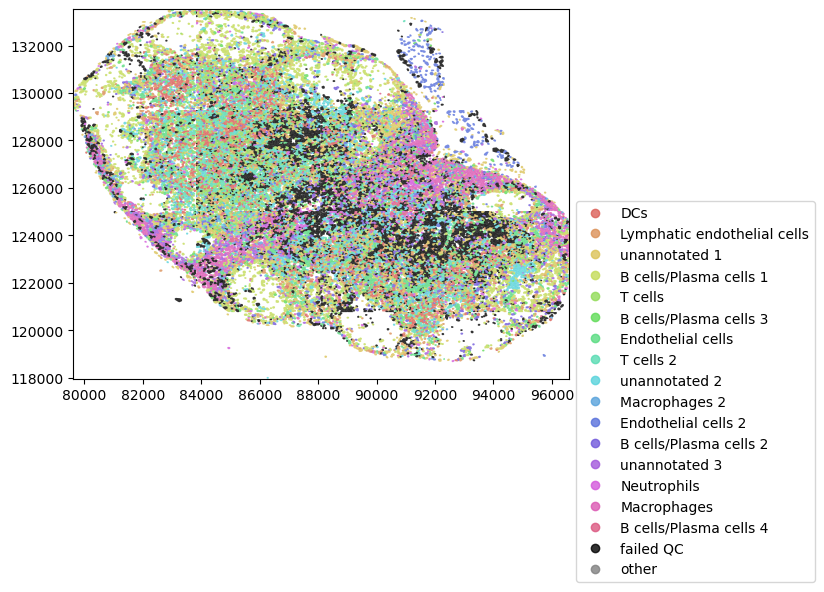

In [40]:
# USE THIS FOR CATEGORICAL VALUES FROM ADATA METADATA
# cells that were filtered out during QC are displayed in black, to distinguish 'gaps' in tissue where no cell was seen or segmented
# from actual cells

var = "celltypes_manual_v2" #"seurat_clusters" "celltypes_manual"
# In case you want to display only a subset of categories and render the rest as other (different value)
allcats = {}
allcats["Mendo"] = ["Macrophages", "Macrophages 2", "Lymphatic endothelial cells", "Endothelial cells", "Endothelial cells 2"] #, "failed QC"]
allcats["TDC"] = ["T cells", "T cells 2", "DCs"]
allcats["BPC"] = ["B cells/Plasma cells 1", "B cells/Plasma cells 2", "B cells/Plasma cells 3","B cells/Plasma cells 4"]
allcats["un"] = ["unannotated 1", "unannotated 2", "unannotated 3"]
allcats["Neutro"] = ["Neutrophils"]
allcats["all"] = []
plotcat = "all"
cats = allcats[plotcat]
img_out= f"{outdir}{sample}_polygons_{var}_{plotcat}.png"

patches = []
fig, ax = plt.subplots()
ax.axis([minx,maxx,miny,maxy])

if len(cats) == 0 :
    cats = [str(r) for r in adata.obs[var].unique()]
cols = dict(zip(cats, sns.color_palette("hls", n_colors = len(cats))))
cols["failed QC"] = "black"
cols["other"] = "grey"

for cell in cells:
    df = fov[fov["cell"] == cell]
    #print(df.shape)
    xy = df[["x_global_px", "y_global_px"]].to_numpy()
    #print(xy)
    try :
        label = str(adata.obs.loc[cell][var])
        if label not in cats : 
            label = "other"      
    except:
        label = "failed QC"
    col = cols[label]

    #print(label, col)
    shape = Polygon(xy, fill = True, facecolor = col, edgecolor = col, alpha = 0.8, linewidth=0.1, label = label)
    ax.add_patch(shape)

    # needs a speed up
    #shape = Polygon(xy, fill = True, facecolor = col, edgecolor = col, alpha = 0.8, linewidth=0.1, label = label)
    #patches.append(shape)

#collection = PatchCollection(patches)
#ax.add_collection(collection)

markers = [plt.Line2D([0,0], [0,0], color = cols[item], alpha = 0.8, marker = 'o', linestyle = '') for item in cols]
ax.legend(markers, cols.keys(), bbox_to_anchor = (1,0.5))
print("Done")

In [ ]:
# USE THIS FOR CONTINUOUS VARIABLES WITH VALUES DERIVED FROM METADATA TABLE (immunofluorescence, count statistics..)

var = "Mean.DAPI"  # "nCount_RNA","Mean.CD298.B2M", "Mean.PanCK",'Mean.DAPI', "Mean.CD45", 'Mean.CD3'
norm = "linear" #"log"

img_out= f"{outdir}{sample}_polygons_"+ var +".png"

patches = []
fig, ax = plt.subplots()
ax.axis([minx,maxx,miny,maxy])

for cell in cells:
    df = fov[fov["cell"] == cell]

    xy = df[["x_global_px", "y_global_px"]].to_numpy()
    shape = Polygon(xy, fill = True) #, facecolor = col, edgecolor = col, alpha = 0.5, linewidth=0.1)
    patches.append(shape)

collection = PatchCollection(patches, cmap="turbo", norm = norm, alpha = 0.5, linewidth=0.1 )# match_original = true )
collection.set_array(adata.obs[var])
ax.add_collection(collection)

fig.colorbar(collection,  fraction=0.03, pad = 0.04)
print("Done")

In [ ]:
# USE THIS FOR CONTINUOUS VARIABLES WITH GENES FROM PANEL (values fetched from adata.X)

var = "C1qa"  # "Hba1_a2_b", "Cd79a"
norm = "linear" #"log"

img_out= f"{outdir}{sample}_polygons_"+ var +".png"

patches = []
fig, ax = plt.subplots()
ax.axis([minx,maxx,miny,maxy])

row = adata.var_names.get_loc(var)
expr = adata.X[row, :]

for cell in cells:
    df = fov[fov["cell"] == cell]

    xy = df[["x_global_px", "y_global_px"]].to_numpy()
    shape = Polygon(xy, fill = True) #, facecolor = col, edgecolor = col, alpha = 0.5, linewidth=0.1)
    patches.append(shape)

collection = PatchCollection(patches, cmap="turbo", norm = norm, alpha = 0.5, linewidth=0.1 )# match_original = true )
collection.set_array(expr)
ax.add_collection(collection)

fig.colorbar(collection,  fraction=0.03, pad = 0.04)
print("Done")

In [41]:
ax.set_title(f"{sample} - {var}")
ax.set_aspect('equal', 'box')

plt.show()

fig.savefig(img_out, format="png", dpi=900, bbox_inches = "tight")